### Content

* [Libraries](#12)
* [Date features](#14)
* [Rolling mean](#15)
* [Model 1 - Linear regression](#16)
* [Model 2 - Decision tree](#20)
* [Model 3 - Random forest](#22)
* [Metrics](#27)
* [Conclusion](#28)


<a id ='12' ></a>
### Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

<a id ='14' ></a>
### Date features

In [5]:
# Date features function
def date_features(df):
    df['date'] = pd.to_datetime(data['date'])
    df['year'] = data.date.dt.year
    df['month'] = data.date.dt.month
    df['day'] = data.date.dt.day
    df['dayofyear'] = data.date.dt.dayofyear
    df['dayofweek'] = data.date.dt.dayofweek
    df['weekofyear'] = data.date.dt.weekofyear
    
    # Additionnal Data Features
    df['day^year'] = np.log((np.log(data['dayofyear'] + 1)) ** (data['year'] - 2000))
    
    # Drop date
    df.drop('date', axis=1, inplace=True)
    
    return df




In [6]:
#applying the function to data
data = date_features(data)

In [7]:
# Daily and monthly average
data['daily_avg']  = data.groupby(['sku','hub_name','dayofweek'])['volume'].transform('mean')
data['monthly_avg'] = data.groupby(['sku','hub_name','month'])['volume'].transform('mean')

In [8]:
# Average sales for Day_of_week = d per sku, hub
daymonth_avg = data.groupby(['sku','hub_name','dayofweek'])['volume'].mean().reset_index()

In [9]:
# Average sales for Month = m per sku, hub
monthly_avg = data.groupby(['sku','hub_name','month'])['volume'].mean().reset_index()

In [10]:
df_1 = data.copy()

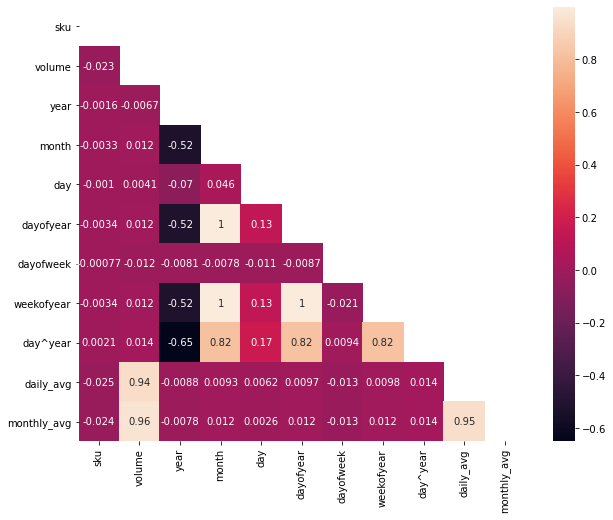

In [11]:
#checking correlations
mask = np.zeros_like(data.corr())

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(data.corr(), mask=mask, annot=True) #mask=mask hides 1 values from above
plt.show()


<a id ='15' ></a>
### Rolling mean

In [12]:
model_0 = df_1.copy()

In [13]:
model_0.corr()['volume'].sort_values(ascending=False)

volume         1.000000
monthly_avg    0.961252
daily_avg      0.936227
day^year       0.013825
weekofyear     0.011894
dayofyear      0.011752
month          0.011535
day            0.004104
year          -0.006732
dayofweek     -0.012150
sku           -0.023492
Name: volume, dtype: float64

In [14]:
# Sales Rolling mean sequence per item 
rolling_10 = model_0.groupby(['sku', 'hub_name'])['volume'].rolling(10).mean().reset_index()
model_0['rolling_mean'] = rolling_10['volume']

In [15]:
# Shifting rolling mean 3 months
model_0['rolling_mean'] = model_0.groupby(['sku'])['rolling_mean'].shift(30)

<a id ='16' ></a>
### Model 1 - Linear regression

In [16]:
model_1 = model_0.copy()

In [17]:
model_1.shape

(411107, 14)

In [18]:
model_1.isna().sum()

sku                  0
hub_name             0
hub_country          0
volume               0
year                 0
month                0
day                  0
dayofyear            0
dayofweek            0
weekofyear           0
day^year             0
daily_avg            0
monthly_avg          0
rolling_mean    110603
dtype: int64

In [19]:
#dropping nulls
#model_1 = model_1.dropna()

In [20]:
#replacing nans with mean
model_1['rolling_mean'] = model_1['rolling_mean'].fillna((model_1['rolling_mean'].mean()))

In [21]:
model_1 = pd.get_dummies(model_1, drop_first=True)

In [22]:
X = model_1.drop('volume', axis=1)
y = model_1['volume']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Features Scaling (except volume)
volume_series = model_1['volume']

In [25]:
# Features Scaling
model_1 = (model_1 - model_1.mean()) / model_1.std()

In [26]:
# Retrieve actual values for volume
model_1['volume'] = volume_series

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [28]:
predictions = model.predict(X_test)
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)


(0.9255288425882681, 9.278804411202698, 76.08383337270374)

In [29]:
dct_LR = {'R2': r2_score(y_test, predictions),'MAE': mean_absolute_error(y_test, predictions), 'RMSE': mean_squared_error(y_test, predictions, squared=False) }

LinearRegression = pd.DataFrame.from_dict(dct_LR, orient = 'index', columns = ["LinearRegression"])
LinearRegression


,LinearRegression
R2,0.925529
MAE,9.278804
RMSE,76.083833


<a id ='20' ></a>
### Model 2 - Decision tree

In [30]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor

In [31]:
model_2 = model_1.copy()

In [32]:
# Features Scaling (except volume)
volume_series = model_2['volume']

In [33]:
# Features Scaling
model_2 = (model_2 - model_2.mean()) / model_2.std()

In [34]:
# Retrieve actual values for volume
model_2['volume'] = volume_series

In [35]:
X = model_2.drop('volume', axis=1)
y = model_2['volume']

In [36]:
X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7525452550431776

In [37]:
predictions = model.predict(X_test)

In [38]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)


(0.7525452550431776, 3.0053892215568863, 4.327471084597094)

In [39]:
dct_DT = {'R2': r2_score(y_test, predictions),'MAE': mean_absolute_error(y_test, predictions), 'RMSE': mean_squared_error(y_test, predictions, squared=False) }

DecisionTree = pd.DataFrame.from_dict(dct_DT, orient = 'index', columns = ["DecisionTree"])
DecisionTree


,DecisionTree
R2,0.752545
MAE,3.005389
RMSE,4.327471


<a id ='22' ></a>
### Model 3 - Random forest

In [40]:
model_3 = model_2.copy()

In [41]:
# Features Scaling (except volume)
volume_series = model_3['volume']

In [42]:
# Features Scaling
model_3 = (model_3 - model_3.mean()) / model_3.std()

In [43]:
# Retrieve actual values for volume
model_3['volume'] = volume_series

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
X = model_3.drop('volume', axis=1)
y = model_3['volume']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
model = RandomForestRegressor(criterion='friedman_mse', max_depth=None, random_state=42, bootstrap=True, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestRegressor(criterion='friedman_mse', n_jobs=-1, random_state=42)

In [48]:
predictions = model.predict(X_test)

In [49]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)


(0.9094863066431473, 9.105759992843584, 85.94904340058764)

In [50]:
dct_RF = {'R2': r2_score(y_test, predictions),'MAE': mean_absolute_error(y_test, predictions), 'RMSE': mean_squared_error(y_test, predictions, squared=False) }

RandomForest = pd.DataFrame.from_dict(dct_RF, orient = 'index', columns = ["RandomForest"])
RandomForest

,RandomForest
R2,0.909486
MAE,9.105760
RMSE,85.949043


In [51]:
import math

results = pd.DataFrame()
results['sku'] = X_test['sku']
results['true'] = y_test
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results

,sku,true,pred,resid
352116,2.034423,3.538462,3.438223,0.100238
137107,-0.449720,20.000000,21.174667,1.174667
96750,-0.591147,6.000000,8.296657,2.296657
275621,-0.398744,5.000000,5.038000,0.038000
229643,-0.420940,8.400000,8.196967,0.203033
...,...,...,...,...
399694,2.042349,4.000000,4.013768,0.013768
280667,-0.361004,10.000000,10.120167,0.120167
402556,2.042381,2.428571,2.493430,0.064858
276715,-0.390225,32.000000,32.220000,0.220000


<AxesSubplot:xlabel='volume'>

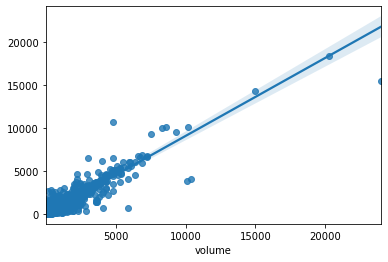

In [52]:
sns.regplot(y_test, predictions)

<a id ='27' ></a>
### Metrics

In [61]:
metrics = pd.concat([LinearRegression, DecisionTree, RandomForest], axis = 1)
metrics

,LinearRegression,DecisionTree,RandomForest
R2,0.925529,0.752545,0.909486
MAE,9.278804,3.005389,9.105760
RMSE,76.083833,4.327471,85.949043


<a id ='28' ></a>
### Conclusion

**Linear regression** and **Random Forest** give the best R2, but the RMSE errors are high. These should be investigated further in future improvements. Spike in volume is extremely important for the production process and may indicate seasonality. The **Decision Tree** model can be given additional attention and different scaling methods can be tried. 

<br>

**Future improvements**:
* try predictions using XBBoost model
* try different scaling methods (MinMax Scaler)
* examine outliers and how to deal with them, as they are important for production volumes
* explore NaN values from a rolling mean
* Use Streamlit to find prices and categories on a customer website
* Build a website using Streamlit to display results for individual days and part numbers.
* Build an ABC analysis for predicted SKUs and volumes and create a new group for stable demand
